In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import os
import time
import configuration
from datetime import datetime
import numpy as np

In [2]:
BASE_PATH = os.getcwd()
NARGO_NOIRKY2_PATH = BASE_PATH + "/nargo_versions/nargo_noirky2"
NARGO_BARRETENBERG_PATH = BASE_PATH + "/nargo_versions/nargo_barretenberg"

In [ ]:
def nargo_build(program_path, executable_path, witness_name, binary_name):
    os.chdir(BASE_PATH+f"/programas_generados/{program_path}")
    subprocess.run([executable_path, "execute", witness_name])
    subprocess.run(["mv", "target/ejemplo.json", f"target/{binary_name}.json"])
    os.chdir(BASE_PATH)
        
def nargo_build_all(executable_path, witness_name, binary_name):
    for program in configuration.sizes_per_program_family.keys():
        for n in configuration.sizes_per_program_family[program]:
            nargo_build(f"{program}/{n}/", executable_path, witness_name, binary_name)

def nargo_noirky2_build_all():
    nargo_build_all(NARGO_NOIRKY2_PATH, "witness_noirky2", "binary_noirky2")

def nargo_barretenberg_build_all():
    nargo_build_all(NARGO_BARRETENBERG_PATH, "witness_bb", "binary_bb")

In [ ]:
#for program in ["range/u8", "range/u16", "range/u32"]:
#    for n in [50000, 100000]:
#        nargo_build(f"{program}/{n}/", NARGO_NOIRKY2_PATH, "witness_noirky2", "binary_noirky2")
#        nargo_build(f"{program}/{n}/", NARGO_BARRETENBERG_PATH, "witness_bb", "binary_bb")

In [ ]:
# Nos aseguramos que el ACIR sea el mismo para ambas versiones
#for program in configuration.program_families:
#    for n in configuration.sizes_per_program_family[program]:
#        os.chdir(BASE_PATH + f"/programas_generados/{program}/{n}")
#        out_noirky2 = subprocess.run([NARGO_NOIRKY2_PATH, "build", "--print-acir"], capture_output=True)
#        out_barretenberg = subprocess.run([NARGO_BARRETENBERG_PATH, "build", "--print-acir"], capture_output=True)
#        assert out_noirky2.stdout == out_barretenberg.stdout
#        os.chdir(BASE_PATH)

In [ ]:
#nargo_barretenberg_build_all()

In [ ]:
#nargo_noirky2_build_all()

In [ ]:
def prove(path_to_backend, path_to_program, path_to_witness, path_to_proof, path_to_binary):
    os.chdir(BASE_PATH+f"/programas_generados/{path_to_program}")
    start_time = time.time()
    subprocess.run([path_to_backend, "prove", "-b", path_to_binary, "-w", path_to_witness, "-o", path_to_proof])
    end_time = time.time()
    os.chdir(BASE_PATH)
    return end_time - start_time

In [ ]:
def write_vk(path_to_backend, path_to_program, path_to_vk, path_to_binary):
    os.chdir(BASE_PATH+f"/programas_generados/{path_to_program}")
    start_time = time.time()
    subprocess.run([path_to_backend, "write_vk", "-b", path_to_binary, "-o", path_to_vk])
    end_time = time.time()
    os.chdir(BASE_PATH)
    return end_time - start_time

In [ ]:
def verify(path_to_backend, path_to_program, path_to_vk, path_to_proof):
    os.chdir(BASE_PATH+f"/programas_generados/{path_to_program}")
    start_time = time.time()
    subprocess.run([path_to_backend, "verify", "-k", path_to_vk, "-p", path_to_proof])
    end_time = time.time()
    os.chdir(BASE_PATH)
    return end_time - start_time

# Experimentación

In [ ]:
comandos = ["prove", "write_vk", "verify"]
ejemplos = configuration.program_families
cantidad_de_iteraciones = 30
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

In [ ]:
backend_base = {
    "noirky2-bits": "noirky2",
    "noirky2-bits-nozk": "noirky2",
    "noirky2-limb": "noirky2",
    "noirky2-limb-nozk": "noirky2",
    "bb": "bb"
}

temp_csv_name = f"mediciones/incremental_{timestamp}.csv"

rows = []
local_rows = []

for comando in ["prove", "write_vk"]:#comandos:
    for ejemplo in ["range/u8", "range/u16", "range/u32"]: #configuration.sizes_per_program_family.keys():
        for backend in configuration.backends_per_program_family[ejemplo]:
            for n in configuration.sizes_per_program_family[ejemplo]:
                for m in range(cantidad_de_iteraciones):
                    time_elapsed = 0
                    backend_base_name = backend_base[backend]
                    if comando == "prove":
                        time_elapsed = prove(
                            f"{BASE_PATH}/backends/{backend}",
                            f"{ejemplo}/{n}",
                            f"target/witness_{backend_base_name}.gz",
                            f"target/proof_{backend}",
                            f"target/binary_{backend_base_name}.json")
                    elif comando == "write_vk":
                        time_elapsed = write_vk(
                            f"{BASE_PATH}/backends/{backend}",
                            f"{ejemplo}/{n}",
                            f"target/vk_{backend}",
                            f"target/binary_{backend_base_name}.json")
                    elif comando == "verify":
                        time_elapsed = verify(
                            f"{BASE_PATH}/backends/{backend}",
                            f"{ejemplo}/{n}",
                            f"target/vk_{backend}",
                            f"target/proof_{backend}")
                    else:
                        print("----------COMANDO DESCONOCIDO------------")
                        pass
                        
                    muestra = {"comando": comando, "backend": backend, "ejemplo": ejemplo, "n": n, "iteracion": m, "tiempo": time_elapsed}
                    print(muestra)
                    rows.append(muestra)
                    local_rows.append(muestra)
                df = pd.DataFrame(local_rows)
                df.to_csv(temp_csv_name, mode="a", header=not os.path.exists(temp_csv_name), index=False)
                local_rows = []  

muestra_headers = ["comando", "backend", "ejemplo", "n", "iteracion", "tiempo"]
df_tiempos = pd.DataFrame(rows, columns = muestra_headers)
df_tiempos

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
filename = f"tiempos_{timestamp}.csv"
df_tiempos.to_csv(f"mediciones/{filename}", index=False)

In [3]:
df_tiempos = pd.read_csv("mediciones/mediciones_finales.csv")

In [4]:
df_tiempos["backend"] = df_tiempos["backend"].replace("noirky2-bits", "Noirky2-operaciones de bits-con blinding")
df_tiempos["backend"] = df_tiempos["backend"].replace("noirky2-bits-nozk", "Noirky2-operaciones de bits-sin blinding")
df_tiempos["backend"] = df_tiempos["backend"].replace("bb", "Barretenberg")
df_tiempos["backend"] = df_tiempos["backend"].replace("noirky2-limb", "Noirky2-Lookup tables-con blinding")
df_tiempos["backend"] = df_tiempos["backend"].replace("noirky2-limb-nozk", "Noirky2-Lookup tables-sin blinding")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("assert_zero", "Assert Zero")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("memory", "Memoria (varía operaciones)")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("memory_wide", "Memoria (varía tamaño de lista)")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("range/u8", "Range-u8")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("range/u16", "Range-u16")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("range/u32", "Range-u32")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("xor/u8", "Xor-u8")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("xor/u16", "Xor-u16")
df_tiempos["ejemplo"] = df_tiempos["ejemplo"].replace("xor/u32", "Xor-u32")

In [ ]:
# ---------- GRAFICOS DE TIEMPOS ---------- #
output_dir = "./mediciones/graficos/tiempo"
os.makedirs(output_dir, exist_ok=True)

def grafico_para_comando(comando, nombre_comando):
    df_comando = df_tiempos[df_tiempos["comando"] == comando]
    for ejemplo, df_ej in df_comando.groupby("ejemplo"):
        plt.figure(figsize=(6,6))
    
        df_plot = df_ej
        x = 'n'
        x_label = "Cantidad de operaciones"
    
        sns.lineplot(
            data=df_plot,
            x=x,
            y='tiempo',
            hue='backend',
            marker='o'
        )
    
        plt.xlabel(x_label)
        plt.ylabel("Tiempo (segundos)")
        plt.title(f"Comando {nombre_comando} - Familia: {ejemplo}")
        plt.legend(title="Backend", loc='upper left')
        if "Range" in ejemplo:
            if comando == "prove": 
                plt.ylim(0, 5)
            if comando == "write_vk":
                plt.ylim(0,3.5)
                
        if comando == "verify":
            plt.legend(title="Backend", loc='upper left', bbox_to_anchor=(0, 0.7))
    
        filename = os.path.join(output_dir, f"{comando}-{ejemplo}.png")
        plt.savefig(filename)
        plt.show()
        plt.close()

In [ ]:
grafico_para_comando("prove", "Prove")

In [ ]:
grafico_para_comando("write_vk", "Write VK")

In [ ]:
grafico_para_comando("verify", "Verify")

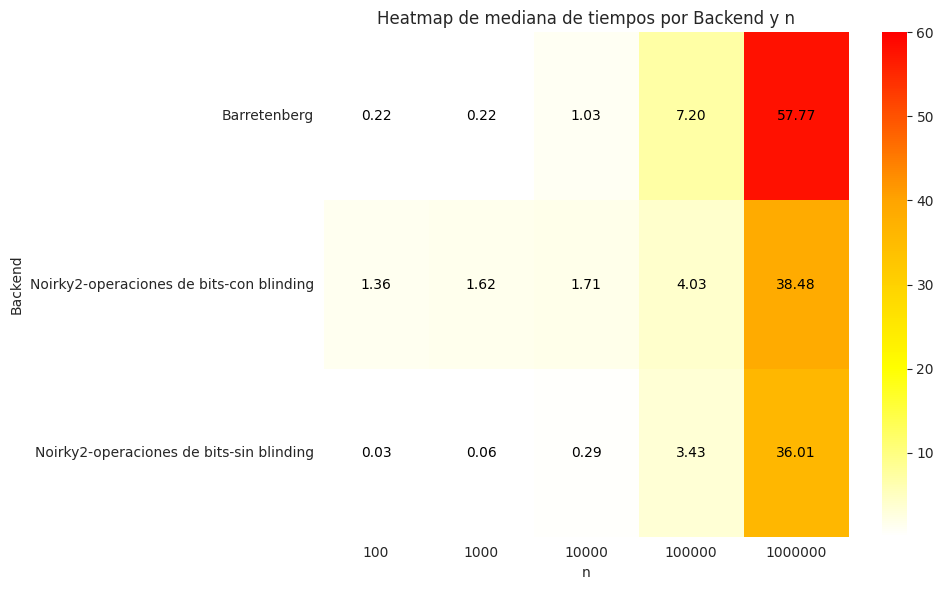

In [28]:
from matplotlib.colors import LinearSegmentedColormap
df_plot = df_tiempos[(df_tiempos["comando"] == "prove") & (df_tiempos["ejemplo"] == "Assert Zero")]
# median_times = df_plot.groupby(["backend", "n"])["tiempo"].median().unstack()
heatmap_data = df_plot.groupby(["backend","n"])["tiempo"].median().unstack()

cmap = LinearSegmentedColormap.from_list("heatmap_cmap", ["white","yellow","orange","red"])

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f",
            cmap=cmap,
            vmin=0.01, vmax=60,
            annot_kws={"color":"black"})

plt.xlabel("n")
plt.ylabel("Backend")
plt.title("Heatmap de mediana de tiempos por Backend y n")
plt.tight_layout()
plt.show()


In [ ]:
# ---------- GRAFICOS DE TIEMPOS Assert Zero (Log) ---------- #
output_dir = "./mediciones/graficos/tiempo"
df_prove = df_tiempos[df_tiempos["comando"] == "prove"]
df_prove = df_prove[df_prove["n"] < 1000000]
df = df_prove[df_prove["ejemplo"] == "Assert Zero"].copy()
plt.figure(figsize=(6,6))
df['n_plot'] = np.log10(df['n'])
x = 'n_plot'
xticks = np.arange(df['n_plot'].min(), df['n_plot'].max()+1)
xticklabels = [int(10**val) for val in xticks]
plt.xticks(xticks, xticklabels)

sns.lineplot(data=df, x=x, y='tiempo', hue='backend', marker='o')

plt.xlabel("Cantidad de operaciones (log)")
plt.ylabel("Tiempo (segundos)")
plt.title(f"Comando Prove - Familia: Assert Zero -log")
plt.legend(title="Backend")
filename = os.path.join(output_dir, f"prove-Assert Zero-log.png")
plt.savefig(filename)
# plt.show()
plt.close()

In [ ]:
df_comparacion_assert_zero_memoria = df_tiempos[
    (df_tiempos["comando"] == "prove") &
    (
            (df_tiempos["ejemplo"] == "Assert Zero") |
            (df_tiempos["ejemplo"] == "Memoria (varía operaciones)") |
            (df_tiempos["ejemplo"] == "Memoria (varía tamaño de lista)")
    ) &
    (df_tiempos["n"] <= 10000)
    &
    (df_tiempos["backend"] == "Barretenberg")
    # (df_tiempos["backend"] == "Noirky2-operaciones de bits-con blinding")
    ]

plt.figure(figsize=(6,6))
sns.lineplot(data=df_comparacion_assert_zero_memoria, x='n', y='tiempo', hue='ejemplo', marker='o')
plt.xlabel("Cantidad de operaciones")
plt.ylabel("Tiempo (segundos)")
plt.title(f"Prove - Assert Zero y Memoria - Backend: Barretenberg con blinding")
plt.legend(title="Familia de programas")
filename = os.path.join("mediciones/graficos/tiempo", f"prove-AssertZero-vs-mem-Barretenberg.png")
plt.savefig(filename)
plt.show()

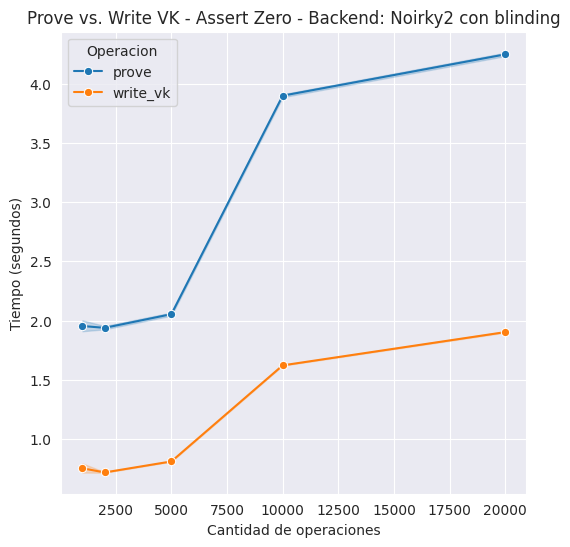

In [23]:
df_prove_vs_vk = df_tiempos[
    ((df_tiempos["comando"] == "prove") | (df_tiempos["comando"] == "write_vk")) 
    # & (df_tiempos["ejemplo"] == "Memoria (varía operaciones)") 
    & (df_tiempos["ejemplo"] == "Xor-u32")
    & (df_tiempos["backend"] == "Noirky2-Lookup tables-con blinding")
    # & (
    #         (df_tiempos["backend"] == "Noirky2-operaciones de bits-con blinding")
    #     | (df_tiempos["backend"] == "Noirky2-Lookup tables-con blinding")
    # )
]

plt.figure(figsize=(6,6))
sns.lineplot(data=df_prove_vs_vk, x='n', y='tiempo', hue='comando', marker='o')
plt.xlabel("Cantidad de operaciones")
plt.ylabel("Tiempo (segundos)")
plt.title(f"Prove vs. Write VK - Assert Zero - Backend: Noirky2 con blinding")
plt.legend(title="Operacion")
filename = os.path.join("mediciones/graficos/tiempo", f"prove-vs-vk-AssertZero-Noirky2.png")
plt.savefig(filename)
plt.show()

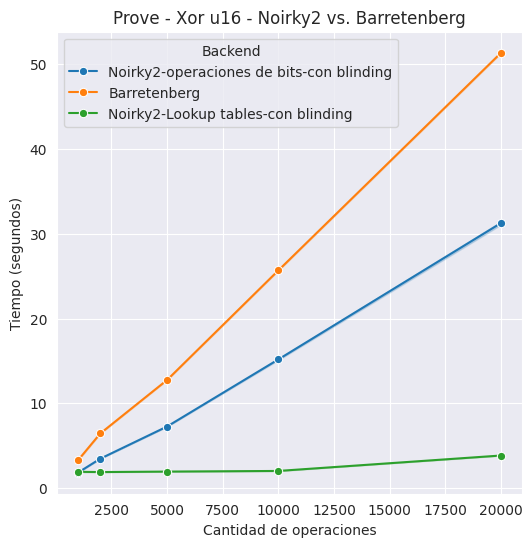

In [35]:
range_ejemplo = df_tiempos[
    (df_tiempos["comando"] == "prove") 
    & (df_tiempos["ejemplo"] == "Xor-u16")
    & ((df_tiempos["backend"] == "Noirky2-operaciones de bits-con blinding") |
        (df_tiempos["backend"] == "Noirky2-Lookup tables-con blinding")
       | (df_tiempos["backend"] == "Barretenberg")
       )
]

plt.figure(figsize=(6,6))
sns.lineplot(data=range_ejemplo, x='n', y='tiempo', hue='backend', marker='o')
plt.xlabel("Cantidad de operaciones")
plt.ylabel("Tiempo (segundos)")
plt.title(f"Prove - Xor u16 - Noirky2 vs. Barretenberg")
plt.legend(title="Backend")
filename = os.path.join("mediciones/graficos/tiempo", f"prove-Xor-u16-Noirky2-vs-Barretenberg.png")
plt.savefig(filename)
plt.show()

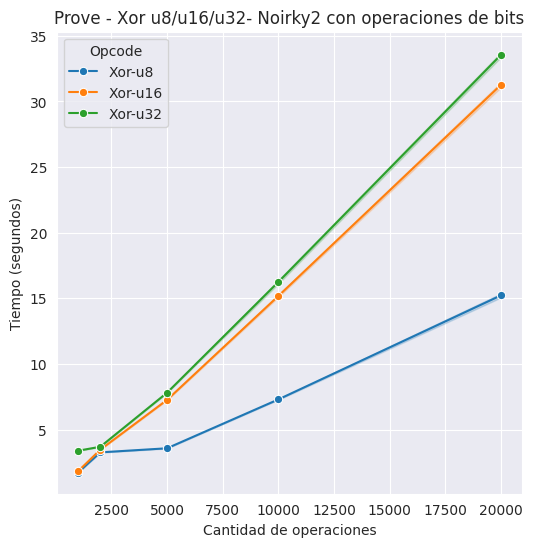

In [5]:
df = df_tiempos[
    (df_tiempos["comando"] == "prove")
    & ((df_tiempos["ejemplo"] == "Xor-u8") | (df_tiempos["ejemplo"] == "Xor-u16") | (df_tiempos["ejemplo"] == "Xor-u32"))
    & (df_tiempos["backend"] == "Noirky2-operaciones de bits-con blinding") 
    ]

plt.figure(figsize=(6,6))
sns.lineplot(data=df, x='n', y='tiempo', hue='ejemplo', marker='o')
plt.xlabel("Cantidad de operaciones")
plt.ylabel("Tiempo (segundos)")
plt.title(f"Prove - Xor u8/u16/u32- Noirky2 con operaciones de bits")
plt.legend(title="Opcode")
filename = os.path.join("mediciones/graficos/tiempo", f"prove-Xor-Noirky2-bits.png")
plt.savefig(filename)
plt.show()

In [ ]:
# OBTENER TAMAÑOS
command_to_artifact = {"prove": "proof", "write_vk": "vk"}
def get_size_in_bytes(comando, backend, ejemplo, n):
    artifact_name = command_to_artifact[comando]
    file_path = f"{BASE_PATH}/programas_generados/{ejemplo}/{n}/target/{artifact_name}_{backend}"
    byte_size = os.path.getsize(file_path)
    print(file_path)
    print(byte_size)
    return byte_size

rows = []

for comando in ["prove", "write_vk"]:
    for ejemplo in ejemplos:
        for backend in configuration.backends_per_program_family[ejemplo]:
            for n in configuration.sizes_per_program_family[ejemplo]:
                byte_size = get_size_in_bytes(comando, backend, ejemplo, n)
                rows.append({"comando": comando, "backend": backend, "ejemplo": ejemplo, "n": n, "byte_size": byte_size})

columns = ["comando", "backend", "ejemplo", "n", "byte_size"]
df_sizes = pd.DataFrame(rows, columns = columns)
df_sizes.to_csv(f"mediciones/tamaños_finales.csv", index=False)
df_sizes

In [ ]:
df_tamanio = pd.read_csv("mediciones/tamaños_finales.csv") 

In [ ]:
df_tamanio["backend"] = df_tamanio["backend"].replace("noirky2-bits", "Noirky2-operaciones de bits-con blinding")
df_tamanio["backend"] = df_tamanio["backend"].replace("noirky2-bits-nozk", "Noirky2-operaciones de bits-sin blinding")
df_tamanio["backend"] = df_tamanio["backend"].replace("bb", "Barretenberg")
df_tamanio["backend"] = df_tamanio["backend"].replace("noirky2-limb", "Noirky2-Lookup tables-con blinding")
df_tamanio["backend"] = df_tamanio["backend"].replace("noirky2-limb-nozk", "Noirky2-Lookup tables-sin blinding")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("assert_zero", "Assert Zero")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("memory", "Memoria (varía operaciones)")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("memory_wide", "Memoria (varía tamaño de lista)")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("range/u8", "Range-u8")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("range/u16", "Range-u16")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("range/u32", "Range-u32")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("xor/u8", "Xor-u8")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("xor/u16", "Xor-u16")
df_tamanio["ejemplo"] = df_tamanio["ejemplo"].replace("xor/u32", "Xor-u32")

df_tamanio["byte_size"] = df_tamanio["byte_size"] / 1024 

In [ ]:
output_dir = "./mediciones/graficos/tamanio"

# ---------- GRAFICOS DE TAMAÑOS ---------- #
def grafico_de_tamanio_para_comando(comando, nombre_comando):
    df_comando = df_tamanio[df_tamanio["comando"] == comando]
    for ejemplo, df_ej in df_comando.groupby("ejemplo"):
        plt.figure(figsize=(6,6))
        df_plot = df_ej
        sns.barplot(data=df_plot, x="n", y="byte_size", hue="backend")
        
        plt.xlabel("Cantidad de operaciones")
        plt.ylabel("Tamaño (kb)")
        plt.title(f"Comando {nombre_comando} - Familia: {ejemplo}")
        plt.legend(title="Backend", loc='upper left')
        if comando == "prove":
            plt.ylim(0, 200)
        elif comando == "write_vk":
            if "Range" in ejemplo:
                plt.ylim(0, 3.6)
            elif "Xor" in ejemplo:
                plt.ylim(0, 375)
            else:
                plt.ylim(0, 2.3)

        filename = os.path.join(output_dir, f"tamanio-{comando}-{ejemplo}.png")
        plt.savefig(filename)
        # plt.show()
        plt.close()

In [ ]:
grafico_de_tamanio_para_comando("prove", "Prove")

In [ ]:
grafico_de_tamanio_para_comando("write_vk", "Verification Key")

In [ ]:
[a / 1024 for a in [121653, 118589, 123094, 129911, 148883]]

In [ ]:
[a/15*762/8/1024 for a in [100, 1000, 10000, 100000, 1000000]]